In [1]:
import os

import numpy as np
from PIL import Image

from tqdm.notebook import tqdm

dataset = {
    "sources": [],
    "size": 0,
    "train": [],
    "val": [],
    "test" : [],
}

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/CT_HD_united_lamiax"
os.chdir(ROOT_DIR)

# Uniting Datasets

## Preparing Dataset

`CT Heart Dataset`

In [2]:
DATA_PATH = "data/datasets/CT_HD_25_nikhilroxtomar/train"

dataset["sources"].append("https://www.kaggle.com/datasets/nikhilroxtomar/ct-heart-segmentation")

In [3]:
# - CT_HD_25_nikhilroxtomar/
# - - train/ < - DATA_PATH
# - - - idx_0/
# - - - - image/
# - - - - - image_0.png
# - - - - ...
# - - - - idx_1/
# - - - - - image_0.png
# - - - - ...
import scipy.ndimage

def zoom(image : np.ndarray, target_shape=(256.0, 256.0, 128.0), order=3):
    scales = [ts / s for s, ts in zip(image.shape, target_shape)]
    scaled_image = scipy.ndimage.zoom(image, scales, mode="reflect", order=order)
    # print(f"source_shape: {image.shape}", f"target_shape:{scaled_image.shape}")
    
    return scaled_image

def convert_png_to_numpy(paths_to_png_files):
    width, height = Image.open(paths_to_png_files[0]).size
    depth = len(paths_to_png_files)
    volume = np.zeros((width, height, depth))
    
    for i, png_file in enumerate(paths_to_png_files):
        image = Image.open(png_file)
        volume[:,:,i] = np.array(image)
    
    volume = volume / 255.0
    
    return volume

data = []
target_shape = (128.0, 128.0, 128.0)

for idx in tqdm(sorted(os.listdir(DATA_PATH))):
    image_path_png = os.path.join(DATA_PATH, idx, "image")
    label_path_png = os.path.join(DATA_PATH, idx, "mask")
    
    image_png = [os.path.join(image_path_png, path) for path in sorted(os.listdir(image_path_png))]
    label_png = [os.path.join(label_path_png, path) for path in sorted(os.listdir(label_path_png))]
    
    # image = convert_png_to_numpy(image_png)
    # label = convert_png_to_numpy(label_png)
    
    # image = zoom(image, target_shape, order=3)
    # label = zoom(label, target_shape, order=0)
    
    image_path = os.path.join(DATASET_PATH, f"ct_nikhilroxtomar_{idx}_image.npy")
    label_path = os.path.join(DATASET_PATH, f"ct_nikhilroxtomar_{idx}_label.npy")
    
    # np.save(image_path, image)
    # np.save(label_path, label)
    
    data.append({"image": image_path,
                "label": label_path,
                "label_map": {
                    "background": {"color": "black", "value": [0.0]},
                    "left ventricle": {"color": "yellow", "value": []},
                    "right ventricle": {"color": "skyblue", "value": []},
                    "left atrium": {"color": "red", "value": []},
                    "right atrium": {"color": "purple", "value": []},
                    "myocarium": {"color": "blue", "value": []},
                    "aorta": {"color": "orange", "value": []},
                    "pulmonary artery": {"color": "green", "value": []},
                    "whole heart": { "color": "white", "value": [1.0] }, # [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 
                }
    })

  0%|          | 0/19 [00:00<?, ?it/s]

In [4]:
from heart_seg_app.utils.dataset import split_dataset
from heart_seg_app.utils.config import save_config

split_ratios = (0.75, 0.2, 0.05)
seed = 0

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATASET_PATH, "dataset.json"))

## Preparing Dataset

`CHD68_segmentation_dataset_miccai19`

In [5]:
import os

import numpy as np
from tqdm.notebook import tqdm

DATA_PATH = "data/datasets/CHD68_segmentation_dataset_miccai19"

dataset["sources"].append("https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19")

In [6]:
# CHD68_segmentation_dataset_miccai19/ < - DATA_PATH
# - ct_1001_image.nii.gz
# - ct_1002_image.nii.gz
# - ...

import re

data = []
target_shape = (128.0, 128.0, 128.0)

image_paths, label_paths = [], []

for path in tqdm(sorted(os.listdir(DATA_PATH))):
    if path.endswith("_image.nii.gz"):
        # image : nib.Nifti1Image = nib.load(os.path.join(DATA_PATH, path))
        # image = image.get_fdata()
        # image = zoom(image, target_shape=target_shape, order=3)
        
        match = re.search(r'\d+', path); idx = match.group()
        image_path = os.path.join(DATASET_PATH, f"ct_xiaoweixumedicalai_{idx}_image.npy")
        image_paths.append(image_path)
        
        # np.save(image_path, image)
    
    if path.endswith("label.nii.gz"):
        # label : nib.Nifti1Image = nib.load(os.path.join(DATA_PATH, path))
        # label = label.get_fdata()
        # label = zoom(label, target_shape=target_shape, order=0)
        
        match = re.search(r'\d+', path); idx = match.group()
        label_path = os.path.join(DATASET_PATH, f"ct_xiaoweixumedicalai_{idx}_label.npy")
        label_paths.append(label_path)
        
        # np.save(label_path, label)
    
for image_path, label_path in zip(image_paths, label_paths):
    data.append({"image": image_path,
                            "label": label_path,
                            "label_map": {
                                "background": {"color": "black", "value": [0.0]},
                                "left ventricle": {"color": "yellow", "value": [1.0]},
                                "right ventricle": {"color": "skyblue", "value": [2.0]},
                                "left atrium": {"color": "red", "value": [3.0]},
                                "right atrium": {"color": "purple", "value": [4.0]},
                                "myocarium": {"color": "blue", "value": [5.0]},
                                "aorta": {"color": "orange", "value": [6.0]},
                                "pulmonary artery": {"color": "green", "value": [7.0]},
                                "whole heart": { "color": "white", "value": [1.0, 2.0, 3.0, 4.0, 5.0] },
                            }})

  0%|          | 0/409 [00:00<?, ?it/s]

In [7]:
from heart_seg_app.utils.dataset import split_dataset
from heart_seg_app.utils.config import save_config

split_ratios = (0.75, 0.2, 0.05)
seed = 0

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATASET_PATH, "dataset.json"))

## Train Models

In [41]:
import os
import torch

from tqdm.notebook import tqdm

from heart_seg_app.utils.config import load_config

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/CT_HD_united_lamiax"
os.chdir(ROOT_DIR)

dataset = load_config(os.path.join(DATASET_PATH, "dataset.json"))

dataset["val"][4]["label_map"]

{'background': {'color': 'black', 'value': [0.0]},
 'left ventricle': {'color': 'yellow', 'value': [1.0]},
 'right ventricle': {'color': 'skyblue', 'value': [2.0]},
 'left atrium': {'color': 'red', 'value': [3.0]},
 'right atrium': {'color': 'purple', 'value': [4.0]},
 'myocarium': {'color': 'blue', 'value': [5.0]},
 'aorta': {'color': 'orange', 'value': [6.0]},
 'pulmonary artery': {'color': 'green', 'value': [7.0]},
 'whole heart': {'color': 'white', 'value': [1.0, 2.0, 3.0, 4.0, 5.0]}}

In [2]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, MapTransform,
    Spacingd, NormalizeIntensityd
)
from monai.data import Dataset, NumpyReader, DataLoader

class ToOneHotExtendedd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = d[key]
            processed_label = torch.zeros((len(d["label_map"].keys()), *label.shape), dtype=torch.float32)
            for i, meta_data in enumerate(d["label_map"].values()):
                value = meta_data["value"]
                for v in value:
                    processed_label[i] = torch.logical_or(processed_label[i], torch.where(label == v, 1.0, 0.0))
            d[key] = processed_label
        
        return d


val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image", "label"]),
    ToOneHotExtendedd(keys=["label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=["image"], channel_wise=True),   
])

val_dataset = Dataset(dataset["val"], transform=val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=1)

## Training Loop

In [3]:
from monai.losses import DiceLoss

class PerChannelDiceLoss(torch.nn.Module):
    def __init__ (self, **kwargs):
        super().__init__()
        self.dice_loss = DiceLoss(**kwargs)
        
    def forward(self, predictions, targets, mask):
        channels = predictions.shape[1]
        
        losses = []
        
        for c in range(channels):
            if mask[c]:
                pred_c = predictions[:, c:c+1, ...]
                target_c = targets[:, c:c+1, ...]
                
                loss_c = self.dice_loss(pred_c, target_c)
                losses.append(loss_c)
                
        return sum(losses) / len(losses)

from monai.networks.nets import UNETR

def create_active_classes_mask(label_map : dict):
    active_classes_mask = torch.zeros(len(label_map.keys()))

    for i, class_meta in enumerate(label_map.values()):
        if len(class_meta["value"]):
            active_classes_mask[i] = 1
            
    return active_classes_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=9,
    img_size=(128, 128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
)
# checkpoint = "./runs/checkpoints/dice-ce-loss-run.pth"
# model.load_state_dict(torch.load(os.path.join(checkpoint), weights_only=True))
model = model.to(device)
model.train()

# loss_function = MaskedDiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
loss_function = PerChannelDiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters())

In [4]:
import matplotlib.colors
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np
from PIL import Image

def create_custom_cmap_extended(label_map : dict):
    pixel_values = [np.array(value["value"][0])[0] for value in label_map.values() if len(value["value"])]
    colors = [value["color"][0] for value in label_map.values()]
    
    if len(pixel_values) < 3:
        return matplotlib.colors.ListedColormap(list(colors), N=len(colors)).with_extremes(under='black', over='white'), None
    
    mid_bounds = [(pixel_values[i] + pixel_values[i+1]) / 2 for i in range(len(pixel_values)-1)]
    custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under='black', over='green')
    norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)
    return custom_cmap, norm

def apply_cmap_to_tensor(tensor : torch.Tensor, cmap : matplotlib.colors.Colormap, norm : matplotlib.colors.Normalize = None):
    tensor = tensor.cpu().numpy()
    if norm is not None:
        tensor = norm(tensor)
    tensor = cmap(tensor) # it converts tensor to numpy rgba image with hwc format, .astype(np.float32)
    tensor = torch.from_numpy(tensor)
    tensor = tensor[:,:,:3] # delete alpha channel
    tensor = tensor.permute(2, 0, 1) # hwc -> chw
    
    return tensor

def make_grid_image_extended(mode : str, image : torch.Tensor, label : torch.Tensor, prediction : torch.Tensor, label_map : dict, idx):
        bone_cmap = plt.get_cmap("bone")

        whs_label_map = dict(list(label_map.items())[:8])
        whs_cmap, whs_norm = create_custom_cmap_extended(whs_label_map)

        heart_label_map = dict(list(label_map.items())[:1] + list(label_map.items())[8:])
        heart_cmap, heart_norm = create_custom_cmap_extended(heart_label_map)

        image = image.squeeze().cpu() # delete batch
        image = apply_cmap_to_tensor(image[:,:,idx].T, bone_cmap)
        
        whs_label = label.squeeze().cpu() # delete batch
        whs_label = torch.argmax(whs_label[:8], dim=0)
        whs_label = apply_cmap_to_tensor(whs_label[:,:,idx].T, whs_cmap, whs_norm)
        
        heart_label = torch.concat((label[:1], label[8:])).squeeze().cpu() # delete batch
        heart_label = torch.argmax(heart_label, dim=0)
        heart_label = apply_cmap_to_tensor(heart_label[:,:,idx].T, heart_cmap, heart_norm)
        
        whs_pred = prediction[:8].squeeze().float().cpu() # delete batch
        whs_pred = torch.argmax(whs_pred, dim=0)
        whs_pred = apply_cmap_to_tensor(whs_pred[:,:,idx].T, whs_cmap, whs_norm)

        heart_pred = torch.concat((prediction[:1], prediction[8:])).squeeze().float().cpu() # delete batch
        heart_pred = torch.argmax(heart_pred, dim=0)
        heart_pred = apply_cmap_to_tensor(heart_pred[:,:,idx].T, heart_cmap, heart_norm)
        
        img_grid = make_grid([image, whs_label, heart_label, whs_pred, heart_pred])
        if mode == "tensorboard":
            return img_grid
        if mode == "eval":
            img_grid = Image.fromarray((img_grid.permute(1, 2, 0).numpy() * 255).astype("uint8"))
        
        return img_grid

In [48]:
def postprocess_outputs_extended(outputs: torch.Tensor, label_values, indices: list):
    selected_outputs = torch.cat([outputs[i].unsqueeze(0) for i in indices], dim=0)
    segmented = torch.softmax(selected_outputs, dim=0).argmax(dim=0)  # 128, 128, 128
    
    return (segmented[None, ...] == torch.tensor(label_values, device=segmented.device)[:, None, None, None]).int()

for batch in val_dataloader:
    inputs, targets = batch["image"].to(device), batch["label"].to(device)
    outputs = model(inputs)
    
    outputs = outputs.as_tensor()
    targets = targets.as_tensor()
    outputs = outputs.squeeze()
    targets = targets.squeeze().int()
    
    
    label_map = batch["label_map"]
    
    label_values = [np.array(v["value"])[0][0] if len(v["value"]) else 0.0 for v in label_map.values()]
    whs_outputs = postprocess_outputs_extended(outputs, list(range(len(label_map.keys())))[:8], indices=list(range(8)))
    heart_outputs = postprocess_outputs_extended(outputs, label_values[:1] + label_values[8:], indices=[0, 8])[1].unsqueeze(0)
    processed_outputs = torch.concat((whs_outputs, heart_outputs))
    
    img_grid = make_grid_image_extended("eval", inputs, targets, processed_outputs, batch["label_map"], 50)
    
    # del whs_outputs, heart_outputs, processed_outputs
    # whs_result = torch.zeros(size=(8, 128, 128, 128), dtype=torch.float32, device="cuda")
    # whs_outputs = outputs.squeeze(0)[:8]
    # whs_outputs = torch.softmax(whs_outputs, dim=0).argmax(dim=0) # 128, 128, 128
    # label_map = batch["label_map"]
    # whs_label_values = list(range(len(label_map.keys())))[:8]
    # for i, value in enumerate(whs_label_values):
    #     whs_result[i] = torch.where(whs_outputs == value, 1, 0)
    
    
    # heart_result = torch.zeros(size=(2, 128, 128, 128), dtype=torch.float32, device="cuda")
    # heart_outputs = outputs.squeeze(0)
    # heart_outputs = torch.concat((heart_outputs[:1], heart_outputs[8:]))
    # heart_outputs = torch.softmax(heart_outputs, dim=0).argmax(dim=0) # 128, 128, 128
    # label_map = batch["label_map"]
    # heart_label_values = [value["value"][0].item() for value in label_map.values() if len(value["value"])]
    # for i, value in enumerate(heart_label_values):
    #     heart_result[i] = torch.where(heart_outputs == value, 1, 0)
    
    
    # del whs_outputs, heart_outputs
    # del whs_result, heart_result
    break
    # print(whs_outputs.shape, whs_outputs.min(), whs_outputs.max())
    
    
    # processed_label = torch.zeros(size=(9, 128, 128, 128), dtype=torch.int32, device="cuda")

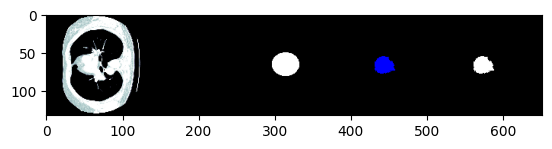

In [49]:
plt.imshow(img_grid)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

1/15: train_loss=0.71984, train_mean_dice=0.15034 by classes:  ['0.71975', '0.000727', '0.0', '0.005192', '0.044979', '0.0', '9.9549e-05', '0.031516', '0.55083']
1/15: val_loss=11.347, val_mean_dice=0.14554 by classes:  ['0.72378', '1.7177e-05', '0.0', '0.0013505', '0.050674', '0.0', '4.6906e-05', '0.045111', '0.48888']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

2/15: train_loss=0.70181, train_mean_dice=0.15222 by classes:  ['0.73828', '0.0', '0.0', '0.00038684', '0.053422', '0.0', '5.3302e-05', '0.032016', '0.54586']
2/15: val_loss=11.023, val_mean_dice=0.15582 by classes:  ['0.75477', '0.0', '0.0', '2.1639e-05', '0.054209', '0.0', '0.0', '0.035185', '0.5582']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

3/15: train_loss=0.68445, train_mean_dice=0.16129 by classes:  ['0.81548', '0.0', '0.0', '0.0', '0.078706', '0.0', '0.0', '0.020368', '0.53707']
3/15: val_loss=10.775, val_mean_dice=0.18111 by classes:  ['0.94126', '0.0', '0.0', '0.0', '0.13253', '0.0', '0.0', '0.017758', '0.53843']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

4/15: train_loss=0.66817, train_mean_dice=0.17725 by classes:  ['0.96362', '0.0', '0.0', '0.0', '0.17411', '0.0', '0.0', '0.00028763', '0.45724']
4/15: val_loss=10.72, val_mean_dice=0.1936 by classes:  ['0.97735', '0.0', '0.0', '0.0', '0.20585', '0.0', '0.0', '8.6298e-05', '0.55908']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

5/15: train_loss=0.65798, train_mean_dice=0.18499 by classes:  ['0.97599', '0.0', '0.0', '0.0', '0.17509', '0.0', '0.0', '0.0', '0.51384']
5/15: val_loss=10.3, val_mean_dice=0.18165 by classes:  ['0.97916', '0.0', '0.0', '0.0', '0.20113', '0.0', '0.0', '0.0', '0.45459']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

6/15: train_loss=0.63765, train_mean_dice=0.19273 by classes:  ['0.97735', '0.0', '0.0', '0.0', '0.1748', '0.0', '0.0', '0.0', '0.58241']
6/15: val_loss=9.9563, val_mean_dice=0.19882 by classes:  ['0.9812', '0.0', '0.0', '0.0', '0.2099', '0.0', '0.0', '0.0', '0.59825']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

7/15: train_loss=0.61814, train_mean_dice=0.19589 by classes:  ['0.97881', '0.0', '0.0', '0.0', '0.18338', '0.0', '0.0', '0.0', '0.60079']
7/15: val_loss=9.7362, val_mean_dice=0.19576 by classes:  ['0.97738', '0.0', '0.0', '0.0', '0.15111', '0.0', '0.0', '0.0', '0.63333']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

8/15: train_loss=0.59863, train_mean_dice=0.20123 by classes:  ['0.979', '0.0', '0.0', '5.8387e-06', '0.18681', '0.0', '0.0', '0.0', '0.64528']
8/15: val_loss=9.2878, val_mean_dice=0.19883 by classes:  ['0.98116', '0.0', '0.0', '8.6739e-06', '0.17739', '0.0', '0.0', '3.4585e-05', '0.63086']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

9/15: train_loss=0.58764, train_mean_dice=0.19711 by classes:  ['0.9781', '0.0', '0.0', '0.0', '0.15811', '0.0', '0.0', '0.00059445', '0.63719']
9/15: val_loss=9.1746, val_mean_dice=0.20218 by classes:  ['0.9797', '0.0', '0.0', '0.0', '0.19951', '0.0', '0.0', '0.0024783', '0.63796']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

10/15: train_loss=0.56887, train_mean_dice=0.19705 by classes:  ['0.97908', '0.0', '0.0', '0.0', '0.17855', '0.0', '0.0', '0.0', '0.61584']
10/15: val_loss=8.8159, val_mean_dice=0.20145 by classes:  ['0.98069', '0.0', '0.0', '0.0', '0.18389', '0.0', '0.0', '0.0', '0.64851']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

11/15: train_loss=0.55577, train_mean_dice=0.19894 by classes:  ['0.97927', '0.0', '0.0', '0.0', '0.18315', '1.7832e-06', '0.0', '0.0', '0.62807']
11/15: val_loss=8.6789, val_mean_dice=0.2056 by classes:  ['0.98023', '0.0', '0.0', '0.0', '0.22016', '8.5509e-06', '0.0', '0.0', '0.65003']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

12/15: train_loss=0.5582, train_mean_dice=0.19794 by classes:  ['0.9776', '0.0', '0.0', '0.0', '0.20229', '5.1314e-05', '0.0', '0.0', '0.6015']
12/15: val_loss=8.6064, val_mean_dice=0.19615 by classes:  ['0.97935', '0.0', '0.0', '0.0', '0.18414', '0.00048748', '0.0', '0.0', '0.60138']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

13/15: train_loss=0.53683, train_mean_dice=0.20245 by classes:  ['0.97981', '0.0', '0.0', '0.0', '0.19524', '0.029565', '0.0', '0.0', '0.61747']
13/15: val_loss=9.1122, val_mean_dice=0.19095 by classes:  ['0.97724', '0.0', '0.0', '0.0', '0.23783', '0.007036', '0.0', '0.0', '0.49648']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

14/15: train_loss=0.52279, train_mean_dice=0.21238 by classes:  ['0.9786', '0.0', '0.0', '0.0', '0.19204', '0.12177', '0.0', '0.0', '0.61901']
14/15: val_loss=8.1485, val_mean_dice=0.21569 by classes:  ['0.97586', '0.0', '0.0', '0.0', '0.16299', '0.23055', '0.0', '0.0', '0.57182']


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

15/15: train_loss=0.50273, train_mean_dice=0.25455 by classes:  ['0.98011', '0.064275', '0.0', '0.0', '0.23999', '0.35501', '0.0', '4.1639e-05', '0.65157']
15/15: val_loss=7.6571, val_mean_dice=0.25801 by classes:  ['0.9798', '0.0019488', '0.0', '0.0', '0.24037', '0.40387', '0.0', '0.0', '0.69607']


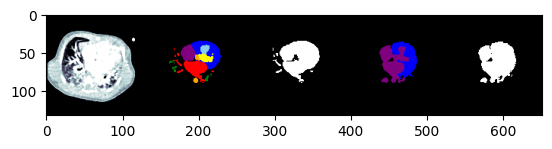

In [47]:
from heart_seg_app.utils.metrics import Metrics

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    train_mean_dice_by_classes = torch.zeros(9, device=device)
    for batch in tqdm(val_dataloader):
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        loss_mask = create_active_classes_mask(batch["label_map"])
        loss = loss_function(outputs, targets, mask=loss_mask)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        outputs = outputs.as_tensor()
        targets = targets.as_tensor()
        outputs = outputs.squeeze()
        targets = targets.squeeze().int()
        
        # label_values = [np.array(v["value"])[0][0] if len(v["value"]) else 0.0 for v in label_map.values()]
        whs_outputs = postprocess_outputs_extended(outputs, list(range(len(label_map.keys())))[:8], indices=list(range(8)))
        heart_outputs = postprocess_outputs_extended(outputs, [0.0, 1.0], indices=[0, 8])[1].unsqueeze(0)
        processed_outputs = torch.concat((whs_outputs, heart_outputs))
        
        metrics = Metrics(processed_outputs, targets)
        mean_dice = metrics.meanDice().item()
        dice_by_classes = metrics.Dice()
        train_mean_dice += mean_dice
        train_mean_dice_by_classes += dice_by_classes
        
    train_loss /= len(val_dataloader)
    train_mean_dice /= len(val_dataloader)
    train_mean_dice_by_classes /= len(val_dataloader)
    
    
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_mean_dice = 0
        val_mean_dice_by_classes = torch.zeros(9, device=device)
        for batch in tqdm(val_dataloader):
            inputs, targets = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            loss_mask = create_active_classes_mask(batch["label_map"])
            loss = loss_function(outputs, targets, mask=loss_mask)  
            val_loss += loss.item()
            
            outputs = outputs.as_tensor()
            targets = targets.as_tensor()
            outputs = outputs.squeeze()
            targets = targets.squeeze().int()
            
            # label_values = [np.array(v["value"])[0][0] if len(v["value"]) else 0.0 for v in label_map.values()]
            whs_outputs = postprocess_outputs_extended(outputs, list(range(len(label_map.keys())))[:8], indices=list(range(8)))
            heart_outputs = postprocess_outputs_extended(outputs, [0.0, 1.0], indices=[0, 8])[1].unsqueeze(0)
            processed_outputs = torch.concat((whs_outputs, heart_outputs))
            
            metrics = Metrics(processed_outputs, targets)
            mean_dice = metrics.meanDice().item()
            dice_by_classes = metrics.Dice()
            val_mean_dice += mean_dice
            val_mean_dice_by_classes += dice_by_classes
        val_mean_dice /= len(val_dataloader)
        val_mean_dice_by_classes /= len(val_dataloader)
        print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}",
                "by classes: ", [f"{elem:.5}" for elem in train_mean_dice_by_classes])
        print(f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}",
                "by classes: ", [f"{elem:.5}" for elem in val_mean_dice_by_classes])
    
        img_grid = make_grid_image_extended("eval", inputs, targets, processed_outputs, batch["label_map"], 50)
    plt.imshow(img_grid)